# Spotify Song Recommender

***

Building a song recommender based off the spotify song features of my listening history.

According to Spotify's Wrapped for 2020, I was in the top 0.5 % of J. Cole's listeners. #realcoleworld. However, spotify has a plethora of songs by millions of artists available and I feel like I am missing out and should explore new songs. So I decided to create a **song recommender to help me classify whether I would like the new song or not**.

## Data

- StreamingHistory.json - personal listening history provided by spotify 
- [tracks.csv](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=tracks.csv) - dataset containing audio features of around 600k songs from kaggle

### Spotipy

[Spotipy](https://spotipy.readthedocs.io) - a lightweight python library for the Spotify Web API - was used to obtain audio features of missing songs.  

## Spotify Song Features

Spotify gives all songs several audio features such as: *danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence and tempo.*

- A great article describing spotify audio features [here](https://medium.com/@boplantinga/what-do-spotifys-audio-features-tell-us-about-this-year-s-eurovision-song-contest-66ad188e112a#379f) 
- Spotify API reference [here](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features)

I'll be using these audio features to find the highest correlation with my **favourite** songs.  


## Dependent variable

The variable 'favourite' will be the prediction variable. I will assign the songs that have **more than or equal to 9 listens** with 1 (favourite) and less than 9 listens as 0 (not favourite). 
When I plotted the number of times I've listen to a specific song on a histogram, a sharp drop off at 9 listens clearly divides the songs that I deliberately listen to and the ones that I clicked on by accident or when I was trying to find new music.

## Objective

To create a song recommender using my Spotify listening history, by comapring Decision Tree and Random Forest classifier models and testing the models' accuracy using F1 score.

## Process

1. [Data Cleaning / Exploration](#data-cleaning)
2. [Feature Selection](#feature-selection) and Oversampling to balance classes
3. [Model Selection](#model-selection) with Cross-validation and Hyperparameter Optimization
4. [Prediction](#prediction) of Songs

## Conclusion

With the Decision Tree Classifier, I got a F1 score of 98% while the Random Forest Classifier got a F1 score of 99%; however, it took significantly more time to hyperparameterize and train the Random Forest.

For 'favourite' on the correlation heatmap:
- positive correlation: **danceability** and **loudness**
- negative correlation: **acousticness**, **instrumentalness** and **valence**

Which indicates that I like loud, easy-to-dance-to 'negative' songs with an emphasis on vocals.

***

# Code

In [69]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

import plotly.graph_objects as go
import plotly.express as px

import plotly.io as pio
from IPython.display import Image

%matplotlib inline

In [70]:
#matplotlib style
plt.style.use('Solarize_Light2')
spotify='#1DB954' #spotify green

In [71]:
#spotify streaming history dataframe
df = pd.read_json("MyData/StreamingHistory.json")
df.head()

,endTime,artistName,trackName,msPlayed
0,2020-06-07 23:55,Samsa,Butterflies,184298
1,2020-06-08 00:10,Chris Wright,Race to the Bottom,917
2,2020-06-08 00:10,Samsa,You'll Say Sorry Through Your Smile,2346
3,2020-06-08 00:10,Chris Wright,Bonfire,7893
4,2020-06-08 00:10,Samsa,One Little Favor,1642


<a id='data-cleaning'></a>

## Data cleaning

In [72]:
#renaming columns
df = df.rename(columns={"artistName":"artist","endTime":"date","trackName":"track"})

#change msPlayed to minsPlayed
df['minsPlayed'] = df.msPlayed.divide(60000)
df.drop('msPlayed', axis=1, inplace=True)

#change date to timestamp format
df['date'] = pd.to_datetime(df.date)

df.head()

,date,artist,track,minsPlayed
0,2020-06-07 23:55:00,Samsa,Butterflies,3.071633
1,2020-06-08 00:10:00,Chris Wright,Race to the Bottom,0.015283
2,2020-06-08 00:10:00,Samsa,You'll Say Sorry Through Your Smile,0.039100
3,2020-06-08 00:10:00,Chris Wright,Bonfire,0.131550
4,2020-06-08 00:10:00,Samsa,One Little Favor,0.027367


#### Streaming history contains podcasts

I manually made a list of podcasts that were in the dataframe and removed every instance of it. 

In [73]:
#list of podcasts
with open("podcasts.txt",'r') as podcasts:
    podcasts_list = podcasts.readlines()
    podcasts_list = list(map(lambda s: s.strip(), podcasts_list))
    print(podcasts_list[:5]) #first 5 podcasts
    
#remove podcasts from artist column
df = df[~df['artist'].isin(podcasts_list)]

['Not Overthinking', 'The Brilliant Idiots', "Dan Carlin's Hardcore History", 'Ear Biscuits', 'The Ringer NBA Show']


## Data exploration

### Total amount of time spent listening to music each day

In [74]:
#seperate date column to day and time
df['day'] = [d.date() for d in df['date']]
df['time'] = [d.time() for d in df['date']]
df.drop('date', axis=1, inplace=True)
df.head()

,artist,track,minsPlayed,day,time
0,Samsa,Butterflies,3.071633,2020-06-07,23:55:00
1,Chris Wright,Race to the Bottom,0.015283,2020-06-08,00:10:00
2,Samsa,You'll Say Sorry Through Your Smile,0.039100,2020-06-08,00:10:00
3,Chris Wright,Bonfire,0.131550,2020-06-08,00:10:00
4,Samsa,One Little Favor,0.027367,2020-06-08,00:10:00


In [75]:
#mins played each day 
day = df.groupby(by=['day'], as_index=False).sum()
day.head()

,day,minsPlayed
0,2020-06-07,3.071633
1,2020-06-08,74.169817
2,2020-06-09,38.736917
3,2020-06-10,39.805917
4,2020-06-11,19.561283


Text(0.5, 1.0, 'Timeline of Streaming History')

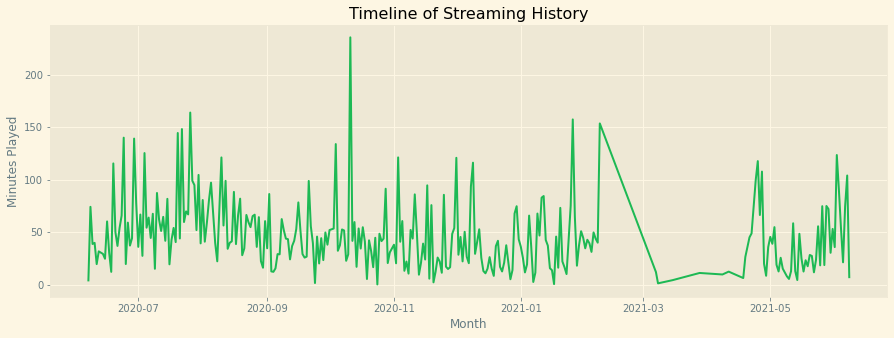

In [76]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(day.day, day.minsPlayed, color=spotify)
ax.set_xlabel('Month')
ax.set_ylabel('Minutes Played')
ax.set_title('Timeline of Streaming History')

#### Why the sudden drop around Febuary of 2021?

I started Army Basic Comabt Training in Febuary 2021 and could only use my phone for 30 mins on Sundays.

### Favourite artists

In [77]:
#top 15 artist by minutes played
minsListened = df.groupby(by='artist')['minsPlayed'].sum().sort_values(ascending=False)[:15]
minsListened

artist
J. Cole              3265.415300
Harry Styles         1061.967717
Rex Orange County     495.454633
Drake                 492.521267
Daniel Caesar         486.141500
Kendrick Lamar        476.459950
Dreamville            465.985067
Kid Cudi              322.465967
Coldplay              261.556867
Arin Ray              260.321467
Chris Brown           224.292567
Ed Sheeran            216.946633
Post Malone           198.958067
Justin Bieber         192.577450
Ty Dolla $ign         161.356650
Name: minsPlayed, dtype: float64

In [78]:
#colors for bar chart
colors = ['RGB(103, 0, 31)','RGB(178, 24, 43)','RGB(214, 96, 77)','RGB(244, 165, 130)','RGB(253, 219, 199)',
          'RGB(247, 247, 247)','RGB(209, 229, 240)','RGB(146, 197, 222)','RGB(67, 147, 195)','RGB(33, 102, 172)',
          'RGB(5, 48, 97)']

In [79]:
#bar chart for total minutes for top 15 artist
fig1 = go.Figure(
    data=[go.Bar(x=minsListened.index,y=minsListened, opacity=1,marker_color=colors)],
    layout_title_text="Total minutes played for Top 15 Artist",
    layout = {'xaxis': {'title': 'Artist Name'}, 'yaxis': {'title': 'Total minutes played'}}
)

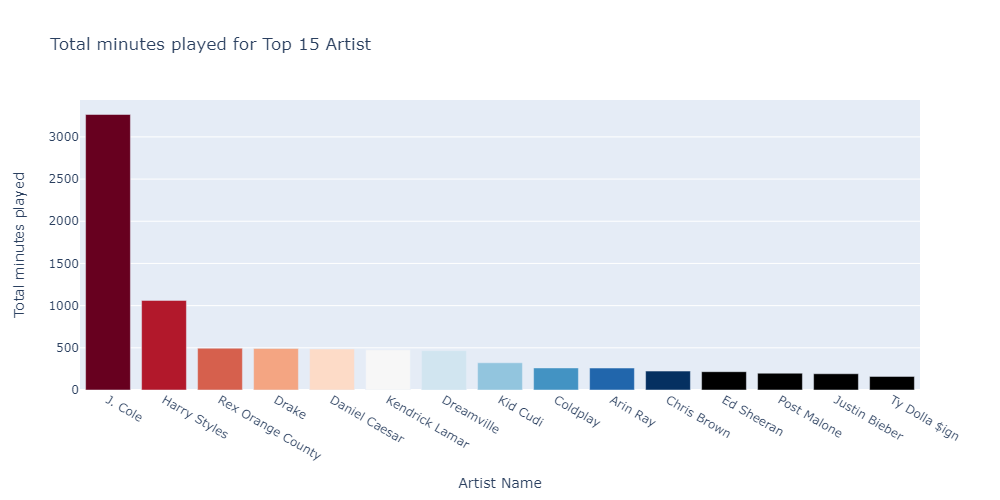

In [80]:
#make bar chart static (github doesn't show interactive plots)
Image(pio.to_image(fig1, format='png', height=500, width=1000))

### Most listened to songs

In [81]:
#total mins played for each track
song = df.groupby(['track'], as_index=False).sum()
song = song.sort_values(by='minsPlayed', ascending=False)
song.head()

,track,minsPlayed
973,Sacrifices (with EARTHGANG & J. Cole feat. Smi...,304.963200
210,Change,236.085850
1391,t h e . c l i m b . b a c k,215.381350
28,4 Your Eyez Only,180.763250
1355,everybody dies,162.870983


In [82]:
#artists for each track
song_artist = df.sort_values(by='track', ascending=False)
song_artist.drop('day', axis=1, inplace=True)
song_artist.drop('time', axis=1, inplace=True)
song_artist.drop('minsPlayed', axis=1, inplace=True)
song_artist.head()

,artist,track
8320,Vicky Chen,炙愛 - 女聲版
7458,Fei Yu-ching,南屏晚鍾
7456,Fei Yu-ching,一翦梅 - xue hua piao piao bei feng xiao xiao
5842,STELPFERD,Оставь меня в покое
1527,Billie Eilish,you should see me in a crown


In [83]:
#remove duplicates of the same track
song_artist = song_artist.drop_duplicates(subset = ["track"])
song_artist.head()

,artist,track
8320,Vicky Chen,炙愛 - 女聲版
7458,Fei Yu-ching,南屏晚鍾
7456,Fei Yu-ching,一翦梅 - xue hua piao piao bei feng xiao xiao
5842,STELPFERD,Оставь меня в покое
1527,Billie Eilish,you should see me in a crown


In [84]:
song = pd.merge(song_artist, song, on='track')
song = song.sort_values(by='minsPlayed', ascending=False)
song.head(15)

,artist,track,minsPlayed
431,Dreamville,Sacrifices (with EARTHGANG & J. Cole feat. Smi...,304.963200
1194,J. Cole,Change,236.085850
13,J. Cole,t h e . c l i m b . b a c k,215.381350
1376,J. Cole,4 Your Eyez Only,180.763250
49,J. Cole,everybody dies,162.870983
779,J. Cole,Kevin’s Heart,160.750717
653,Kendrick Lamar,Money Trees,160.608067
320,Harry Styles,"Sunflower, Vol. 6",160.426250
490,Ty Dolla $ign,Purple Emoji (feat. J. Cole),157.720300
971,Harry Styles,Golden,154.264683


In [85]:
#top 15 songs by mins played
song = song.sort_values(by='minsPlayed', ascending=False)
song.reset_index(inplace = True, drop = True) 
top15 = song[:16]

In [86]:
#bar chart for most listened to songs
fig2 = px.bar(top15, x="track", y="minsPlayed", 
             title = 'Most Listened To Songs', 
             labels={'track':'Track Name',
                     'minsPlayed':'Total minutes played'},
             color = "artist", 
             color_discrete_sequence=px.colors.sequential.RdBu)

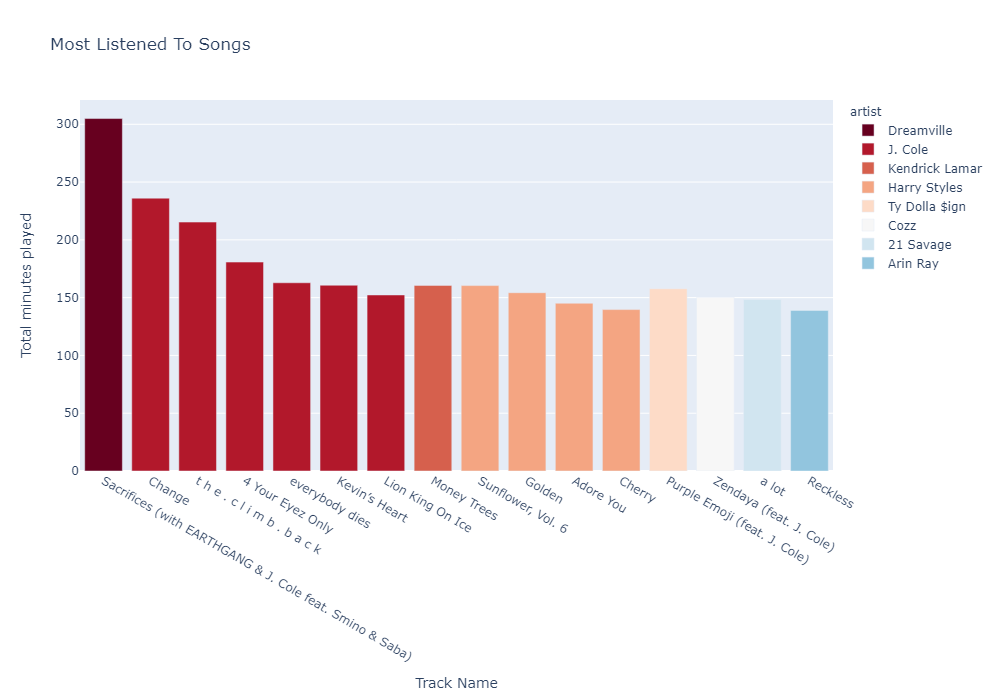

In [87]:
#make bar chart static 
Image(pio.to_image(fig2, format='png', height=700, width=1000))

<a id='feature-selection'></a>

### Favourite song

In [17]:
#dataframe of counts by artist and track
count = df.groupby(['artist','track']).size().to_frame('count').reset_index()
count.head()

,artist,track,count
0,$NOT,Moon & Stars (feat. Maggie Lindemann),1
1,03 Greedo,Trap House (feat. Shoreline Mafia),1
2,070 Shake,Guilty Conscience,1
3,1020Meezy,Mobties,1
4,21 Savage,Mr. Right Now (feat. Drake),2


Text(0.5, 1.0, "Determining 'favourite' song")

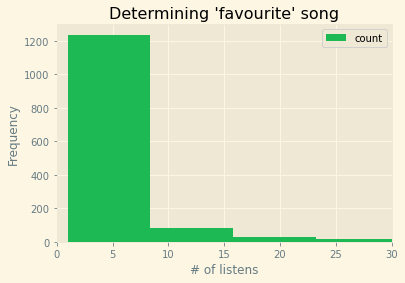

In [18]:
#determine how many listens makes a song 'favourite'
ax = count.plot(kind='hist',color=spotify)
ax.set_xlim(0,30)
ax.set_xlabel("# of listens")
ax.set_title("Determining 'favourite' song")

#### How to determine what is a "favourite" song?

A sharp drop off at 9 listens of a song on the histogram clearly divides the songs that I deliberately listen to and the ones that I clicked on by accident or when I was trying to find new music.

In [19]:
#dataframe of songs with only count >= 9
fav = count[count['count']>=9]
fav = fav.sort_values(by='count', ascending=False).reset_index(drop=True)
fav

,artist,track,count
0,Ty Dolla $ign,Purple Emoji (feat. J. Cole),75
1,Dreamville,Sacrifices (with EARTHGANG & J. Cole feat. Smi...,73
2,J. Cole,everybody dies,73
3,J. Cole,Change,70
4,J. Cole,t h e . c l i m b . b a c k,69
...,...,...,...
186,The Neighbourhood,Sweater Weather,9
187,Dean Lewis,Be Alright,9
188,Doja Cat,Say So,9
189,Arizona Zervas,ROXANNE,9


### Audio features of ~600k  songs

In [20]:
#Audio features of ~600k songs released between 1922 and 2021 from Kaggle
features = pd.read_csv("tracks.csv")
#renaming columns
features = features.rename(columns={"artists":"artist","name":"track"})
features.head()

,id,track,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [21]:
#removing square brackets and quotation marks in the artist column
features['artist'] = features['artist'].str.replace("[\[\]']", '')
features.artist

0                               Uli
1                   Fernando Pessoa
2                   Ignacio Corsini
3                   Ignacio Corsini
4                       Dick Haymes
                    ...            
586667                      阿YueYue
586668                   ROLE MODEL
586669                      FINNEAS
586670    Gentle Bones, Clara Benin
586671                    Afrosound
Name: artist, Length: 586672, dtype: object

In [22]:
#creating columns with True if same artist/track in features dataframe
features['same_artists'] = features.artist.isin(fav.artist) 
features['same_track'] = features.track.isin(fav.track)

#if both are True, set favourite column to 1
features["favourite"] = np.where((features["same_artists"] == True) & (features["same_track"] == True),np.float(1),0)
features = features.drop(["same_artists","same_track"],axis=1)

features

,id,track,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,favourite
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,0.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,0.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,0.0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,0.0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586667,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,...,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.0
586668,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,...,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.0
586669,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,FINNEAS,['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,...,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,0.0
586670,45XJsGpFTyzbzeWK8VzR8S,A Day At A Time,58,142003,0,"Gentle Bones, Clara Benin","['4jGPdu95icCKVF31CcFKbS', '5ebPSE9YI5aLeZ1Z2g...",2021-03-05,0.696,0.6150,...,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,0.0


In [23]:
#duplicated tracks in feature dataframe
duplicateTracks = features[features.duplicated(['track'])]
duplicateTracks

,id,track,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,favourite
121,5cUFFY2Atw4QeFitueQCt2,El Huerfano - Remasterizado,0,159800,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.366,0.0749,...,-26.340,1,0.0806,0.996,0.924,0.1170,0.515,90.969,3,0.0
187,300WVfsVnOUJM2KXAm9IGS,Stardust,8,205533,0,Louis Armstrong,['19eLuQmk9aCobbVDHc6eek'],1923,0.717,0.2090,...,-13.224,1,0.0622,0.979,0.439,0.0609,0.889,127.401,4,0.0
230,5eXOIVUkW17FqnEoLR2wTX,Stardust,5,213667,0,Louis Armstrong,['19eLuQmk9aCobbVDHc6eek'],1923,0.614,0.2980,...,-11.004,0,0.0541,0.970,0.646,0.0514,0.772,122.319,4,0.0
398,2gFUqcLFUDVXcWmeKAOnGd,Pobre Cotorro - Remasterizado,0,171107,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1923-03-29,0.502,0.2980,...,-15.321,0,0.0805,0.995,0.919,0.2850,0.510,135.238,4,0.0
472,3lWtpc2gKflv5xG7qGVA9l,I Can't Give You Anything But Love,0,184059,0,Harry Curtis,['3E3AwPbm9ShPKXVDsMp5Zy'],1923,0.733,0.5160,...,-11.970,1,0.0475,0.859,0.000,0.0913,0.779,139.964,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586649,0MmaEacabpK8Yp3Mdeo5uY,下雨天,50,265846,0,芝麻,['5VGgFE9nPgMfEnYiPT5J2B'],2020-02-25,0.528,0.6730,...,-3.639,1,0.0314,0.143,0.000,0.0989,0.297,130.066,4,0.0
586654,6sHxpnCerm9M6A5zaFFNfs,Gone,66,205462,0,Blake Rose,['7wLyGTO9vUS7ndlq4BvBGe'],2020-02-07,0.317,0.5450,...,-6.439,0,0.0469,0.039,0.000,0.1160,0.140,139.014,5,0.0
586660,4SMp3hkQV64IoaaKsBQoBo,Edelweiss,65,123500,0,Ludovico Sagese,['1dygDSkQGQOfq1ZdChpOCs'],2020-02-14,0.465,0.0289,...,-27.689,1,0.0430,0.996,0.959,0.1360,0.448,99.873,3,0.0
586666,1ZwZsVZUiyFwIHMNpI3ERt,Skyscraper,4,106002,0,Emilie Chin,['4USdOnfLczwUglA3TrdHs2'],2020-02-08,0.626,0.5300,...,-13.117,0,0.0284,0.113,0.856,0.1040,0.215,120.113,4,0.0


In [24]:
#removing duplicates 
features.drop_duplicates(subset=['track'], inplace = True, keep='first')
features.reset_index(drop=True, inplace=True)
features

,id,track,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,favourite
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,0.0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,0.0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,0.0
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,0.0
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446470,0SjsIzJkZfDU7wlcdklEFR,John Brown's Song,66,185250,0,Gregory Oberle,['4MxqhahGRT4BPz1PilXGeu'],2020-03-20,0.562,0.0331,...,-25.551,1,0.1030,0.996,0.961000,0.1110,0.3860,63.696,3,0.0
446471,5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,阿YueYue,['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,...,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,0.0
446472,0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,ROLE MODEL,['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,...,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,0.0
446473,27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,FINNEAS,['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,...,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,0.0


In [25]:
#for prediction in future
future = features.copy(deep=True)

In [26]:
#favourite songs' audio features
favFeatures = features[features.favourite == 1].reset_index(drop=True)
favFeatures

,id,track,popularity,duration_ms,explicit,artist,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,favourite
0,4u7EnebtmKWzUH433cf5Qv,Bohemian Rhapsody - Remastered 2011,83,354320,0,Queen,['1dfeR4HaWDbWqFHLkxsg1d'],1975-11-21,0.414,0.404,...,-9.928,0,0.0499,0.271000,0.000000,0.3000,0.224,71.105,4,1.0
1,4BM8yJ0PzBi2ZewpMTOxtx,Fernando,68,252960,0,ABBA,['0LcJLqbBmaGUft1e9Mm8HV'],1976,0.354,0.535,...,-8.876,1,0.0303,0.627000,0.000003,0.0808,0.434,110.821,4,1.0
2,5qqabIl2vWzo9ApSC317sa,Wonderwall - Remastered,79,258773,0,Oasis,['2DaxqgrOhkeH0fpeiQq2f4'],1995-10-02,0.378,0.896,...,-4.066,1,0.0407,0.000452,0.000000,0.1940,0.469,174.302,4,1.0
3,3AJwUDP919kvQ9QcozQPxg,Yellow,86,266773,0,Coldplay,['4gzpq5DPGxSnKTe4SA8HAU'],2000-07-10,0.429,0.661,...,-7.227,1,0.0281,0.002390,0.000121,0.2340,0.285,173.372,4,1.0
4,0I3q5fE6wg7LIfHGngUTnV,Ms. Jackson,82,270507,1,Outkast,['1G9G7WwrXka3Z1r7aIDjI7'],2000-10-31,0.843,0.806,...,-5.946,0,0.2690,0.143000,0.000000,0.0771,0.613,94.948,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,4hWgC5BV5M7EtTleKVXNxw,Playing Games,68,143667,1,Summer Walker,['57LYzLEk2LcFghVwuWbcuS'],2019-10-04,0.759,0.413,...,-7.282,0,0.0494,0.700000,0.000000,0.1400,0.403,115.893,4,1.0
64,4RHyIzFRht2z17XeHB9dsF,Through and Through,69,113684,0,khai dreams,['0lawSNBxNgJFQYJnQzLH8c'],2017-12-04,0.851,0.424,...,-9.307,1,0.0463,0.383000,0.000000,0.0843,0.591,94.927,4,1.0
65,3xaugmCyXrVkrDTXbFkMW3,Sanctuary,72,180019,0,Joji,['3MZsBdqDrRTJihTHQrO6Dq'],2019-06-14,0.552,0.650,...,-7.199,1,0.1280,0.422000,0.000275,0.3720,0.316,167.788,4,1.0
66,63bAGRSSX2V1hhPSP2NpBC,North Face,69,196800,1,ODIE,['5aMIbwZQvP2MHPMVC5zCGj'],2018-04-06,0.802,0.382,...,-7.356,1,0.0312,0.792000,0.163000,0.0783,0.581,99.969,4,1.0


#### favFeatures missing songs, should have 191 songs according to fav dataframe

To obtain the audio features of the missing songs, I used **spotipy** - a lightweight python library for the Spotify Web API. I converted 'fav' and 'favFeatures' into csv files and got the missing audio features on a seperate notebook named missing-features. The output of that notebook is the missingFeatures dataframe below.

In [27]:
#dataset of songs' audio features that were missing from features dataframe
missingFeatures = pd.read_csv("missingFeatures.csv")
missingFeatures

,id,track,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,favourite
0,3OJ4LEE50iFELaHiZ09zif,Purple Emoji (feat. J. Cole),163755,0.707,0.543,8,-4.610,1,0.2790,0.1510,0.000000,0.3840,0.824,144.180,4,1.0
1,7wTA0NKIm6T7nP2kaymU2a,Sacrifices (with EARTHGANG & J. Cole feat. Smi...,382307,0.825,0.672,0,-7.108,1,0.4180,0.0858,0.000000,0.1230,0.246,147.010,4,1.0
2,0I1eFRytp4XRhLCjT6tZm7,Change,198213,0.247,0.438,5,-8.479,1,0.0358,0.0455,0.000871,0.1110,0.390,185.716,3,1.0
3,5lLNBIyjp72btcnrjBG751,t h e . c l i m b . b a c k,306257,0.618,0.632,11,-6.973,1,0.3460,0.0526,0.000000,0.3530,0.319,81.446,4,1.0
4,4at3d5QWnlibMVN75ECDrp,Pretty Little Fears (feat. J. Cole),240342,0.610,0.458,9,-11.336,1,0.3600,0.6960,0.000103,0.0852,0.246,192.099,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,3EPXxR3ImUwfayaurPi3cm,Be Alright,196373,0.553,0.586,11,-6.319,1,0.0362,0.6970,0.000000,0.0813,0.443,126.684,4,1.0
119,4evmHXcjt3bTUHD1cvny97,Beautiful People (feat. Khalid),197867,0.640,0.648,5,-8.113,0,0.1870,0.1240,0.000000,0.0802,0.548,92.977,4,1.0
120,47r6MeqPoeQgCsa5vOQxoo,Honesty (Remix) [feat. Jessie Reyez],187805,0.725,0.374,6,-6.501,0,0.0395,0.7730,0.000000,0.1110,0.344,80.032,4,1.0
121,7ILEWkpfdK6AjH2D7jppWk,Don't Check On Me (feat. Justin Bieber & Ink),204880,0.661,0.395,7,-5.242,1,0.0333,0.8730,0.000000,0.1120,0.679,82.028,4,1.0


#### dropping columns that won't help with the prediction.

In [28]:
#removing unnecessary columns
features = features.drop(columns=['id', 'track', 'popularity', 'explicit', 'artist', 'id_artists', 
                                  'release_date', 'key', 'mode', 'time_signature'])
features

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,favourite
0,126903,0.645,0.4450,-13.338,0.4510,0.674,0.744000,0.1510,0.1270,104.851,0.0
1,98200,0.695,0.2630,-22.136,0.9570,0.797,0.000000,0.1480,0.6550,102.009,0.0
2,181640,0.434,0.1770,-21.180,0.0512,0.994,0.021800,0.2120,0.4570,130.418,0.0
3,176907,0.321,0.0946,-27.961,0.0504,0.995,0.918000,0.1040,0.3970,169.980,0.0
4,163080,0.402,0.1580,-16.900,0.0390,0.989,0.130000,0.3110,0.1960,103.220,0.0
...,...,...,...,...,...,...,...,...,...,...,...
446470,185250,0.562,0.0331,-25.551,0.1030,0.996,0.961000,0.1110,0.3860,63.696,0.0
446471,258267,0.560,0.5180,-7.471,0.0292,0.785,0.000000,0.0648,0.2110,131.896,0.0
446472,153293,0.765,0.6630,-5.223,0.0652,0.141,0.000297,0.0924,0.6860,150.091,0.0
446473,187601,0.535,0.3140,-12.823,0.0408,0.895,0.000150,0.0874,0.0663,145.095,0.0


In [29]:
#removing unnecessary columns
missingFeatures = missingFeatures.drop(columns=['id', 'key', 'track','mode', 'time_signature'])
missingFeatures

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,favourite
0,163755,0.707,0.543,-4.610,0.2790,0.1510,0.000000,0.3840,0.824,144.180,1.0
1,382307,0.825,0.672,-7.108,0.4180,0.0858,0.000000,0.1230,0.246,147.010,1.0
2,198213,0.247,0.438,-8.479,0.0358,0.0455,0.000871,0.1110,0.390,185.716,1.0
3,306257,0.618,0.632,-6.973,0.3460,0.0526,0.000000,0.3530,0.319,81.446,1.0
4,240342,0.610,0.458,-11.336,0.3600,0.6960,0.000103,0.0852,0.246,192.099,1.0
...,...,...,...,...,...,...,...,...,...,...,...
118,196373,0.553,0.586,-6.319,0.0362,0.6970,0.000000,0.0813,0.443,126.684,1.0
119,197867,0.640,0.648,-8.113,0.1870,0.1240,0.000000,0.0802,0.548,92.977,1.0
120,187805,0.725,0.374,-6.501,0.0395,0.7730,0.000000,0.1110,0.344,80.032,1.0
121,204880,0.661,0.395,-5.242,0.0333,0.8730,0.000000,0.1120,0.679,82.028,1.0


In [30]:
#concating missingFeatures with features dataframe
features = pd.concat([features, missingFeatures])
features

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,favourite
0,126903,0.645,0.4450,-13.338,0.4510,0.6740,0.7440,0.1510,0.127,104.851,0.0
1,98200,0.695,0.2630,-22.136,0.9570,0.7970,0.0000,0.1480,0.655,102.009,0.0
2,181640,0.434,0.1770,-21.180,0.0512,0.9940,0.0218,0.2120,0.457,130.418,0.0
3,176907,0.321,0.0946,-27.961,0.0504,0.9950,0.9180,0.1040,0.397,169.980,0.0
4,163080,0.402,0.1580,-16.900,0.0390,0.9890,0.1300,0.3110,0.196,103.220,0.0
...,...,...,...,...,...,...,...,...,...,...,...
118,196373,0.553,0.5860,-6.319,0.0362,0.6970,0.0000,0.0813,0.443,126.684,1.0
119,197867,0.640,0.6480,-8.113,0.1870,0.1240,0.0000,0.0802,0.548,92.977,1.0
120,187805,0.725,0.3740,-6.501,0.0395,0.7730,0.0000,0.1110,0.344,80.032,1.0
121,204880,0.661,0.3950,-5.242,0.0333,0.8730,0.0000,0.1120,0.679,82.028,1.0


## Oversampling with SMOTE

In [31]:
#imbalance between favourite (1) and not favourite (0)
features.favourite.value_counts()

0.0    446407
1.0       191
Name: favourite, dtype: int64

Since the classes are severely imbalanced the models will have poor performace since they will likely ignore the minority class entirey. To tackle this problem, I will apply SMOTE (**Synthetic Minority Oversampling Technique**) to oversample the minority class to blance the classes out.

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
X = features.drop(columns=['favourite'])
y = features.favourite
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X['favourite'] = y

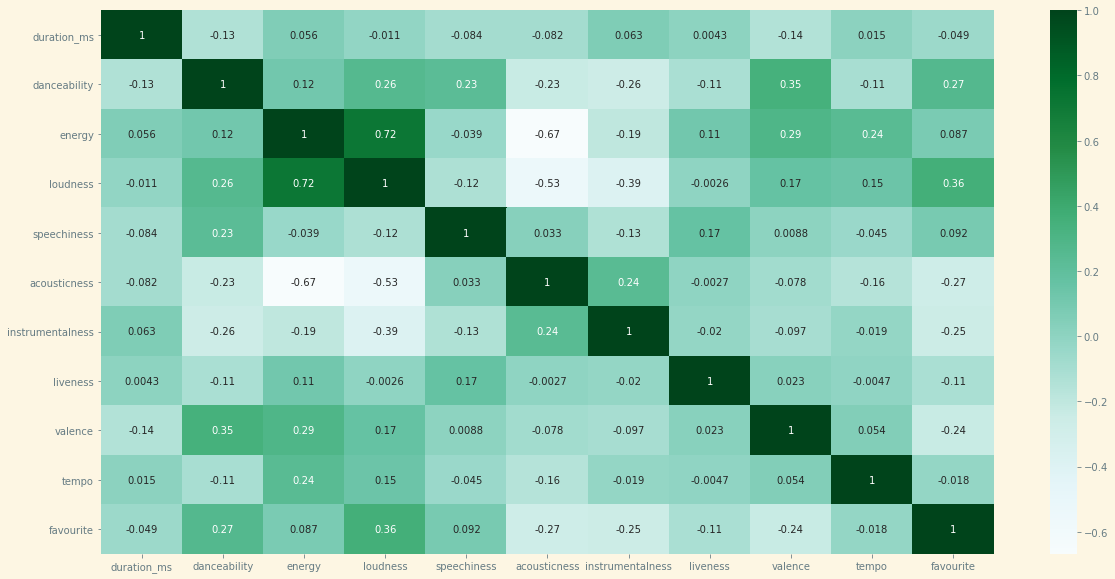

In [34]:
#correlation heatmap of audio features
plt.figure(figsize=(20,10))
c = X.corr()
corr = sns.heatmap(c,cmap="BuGn",annot=True)

For 'favourite'
- positive correlation: **danceability** and **loudness**
- negative correlation: **acousticness**, **instrumentalness** and **valence**

These 5 audio features will be used in the models.

<a id="model-selection"></a>

## Model

In [35]:
#importing libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score

#models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [36]:
#train/test split data
X_train, X_test, y_train, y_test = train_test_split(features.drop(columns='favourite'), 
                                                    features.favourite, test_size = .20, random_state=10)

important to split data before applying SMOTE to prevent data leakage.

In [37]:
#SMOTE on train data
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

### Decision Tree Classifier

In [38]:
dt = DecisionTreeClassifier()

In [39]:
%%time
#hyperparameter optimization for Decision Tree Classifier
parameters = {'max_depth':[15,20,30]}
dt_grid = GridSearchCV(dt, parameters, cv = 5, scoring='f1')
dt_grid.fit(X_train, y_train)
dt_grid.best_params_

Wall time: 3min 3s


{'max_depth': 30}

In [40]:
%%time
dt = DecisionTreeClassifier(max_depth=30)
np.mean(cross_val_score(dt, X_train, y_train, cv=10, scoring="f1"))

Wall time: 2min 41s


0.9889912436191886

### Random Forest Classifier

In [41]:
rf = RandomForestClassifier()

In [42]:
%%time
#hyperparameter optimization of RandomForestClassifier
parameters = {'max_depth':[6,12,15,20],'n_estimators':[20,30]}
rf_grid = GridSearchCV(rf, parameters, cv = 5)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_

Wall time: 41min 25s


{'max_depth': 20, 'n_estimators': 20}

In [43]:
%%time
#Cross-validation for RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 20, max_depth = 30)
np.mean(cross_val_score(rf, X_train, y_train, cv=10, scoring="f1"))

Wall time: 21min 20s


0.994492710576495

#### Since training dataset is big, it is time consuming to train the model. Saving the models to pickle files means we won't have to train them everytime.

In [41]:
import pickle

In [42]:
#save decision tree model as pickle file
with open('dt_pickle','wb') as f:
    pickle.dump(dt,f)

<a id="prediction"></a>

## Prediction

In [43]:
dt = pd.read_pickle('dt_pickle')

In [44]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=30)

In [45]:
prediction = dt.predict(future.drop(columns=['id', 'track', 'popularity', 'explicit', 'artist', 'id_artists', 
                                             'release_date', 'key', 'mode', 'time_signature', 'favourite']))

In [46]:
future['prediction'] = prediction

In [47]:
#songs that were not favourite but predicted to be
future = future[(future['favourite']==0) & (future['prediction'] == 1)]

In [48]:
future = future.drop(columns=['popularity', 'duration_ms', 'explicit', 'id_artists',
                                  'release_date', 'energy', 'key', 'mode', 'speechiness',
                                  'liveness', 'tempo', 'time_signature'])

In [49]:
future

,id,track,artist,danceability,loudness,acousticness,instrumentalness,valence,favourite,prediction
2524,0dHWUBSmoHz956UurOZ9Ua,Higher Power Part Duece,Numba 9,0.609,-8.685,0.1980,0.000064,0.566,0.0,1.0
2593,1EP3FZb36DEY1RsrZiZ4lD,Ole Bitch,Numba 9,0.436,-3.178,0.0486,0.000000,0.666,0.0,1.0
5182,1BYj2lRr4DiQbuJKQ13MO9,Up There,"Shorty Bralik, ParkPlace Swagg",0.761,-9.919,0.6010,0.000000,0.369,0.0,1.0
6536,0Dg9RljBGiHvmsgmKLDK58,Che bambola,Fred Buscaglione,0.586,-9.960,0.8800,0.000000,0.533,0.0,1.0
7754,5T2sgRtxnb5C19WjooNL63,Las Palomas de Guachupita,Antonio Morel,0.428,-10.930,0.3040,0.019900,0.791,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
446380,798ZCZmdRxtWuZNF6E92W3,2015新版孤單北半球,歐得洋,0.618,-7.224,0.5990,0.000000,0.431,0.0,1.0
446403,4OSl72bTia7Hrn8xfRKjbM,Stop Sugar,Gen Neo,0.574,-5.815,0.1470,0.000000,0.518,0.0,1.0
446466,27kcZEJvhkb1rzZS9gCpdA,remember the mornings,Clinton Kane,0.590,-5.662,0.6180,0.000000,0.342,0.0,1.0
446472,0NuWgxEp51CutD2pJoF4OM,blind,ROLE MODEL,0.765,-5.223,0.1410,0.000297,0.686,0.0,1.0


In [51]:
#saving to csv file
future.to_csv("dt_recommendations.csv")

Using a python script, the CSV file can automatically be made into a Spotify playlist.